#### *Bringing necessary libraries*

In [1]:
from __future__ import print_function, division

import torch
import argparse
import json 
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from functools import partial 
import time
import os
import random
import copy
import pdb 
from tqdm import tqdm
from _utils import accuracy
import matplotlib.pyplot as plt

#### *Transforming images to tensor and normalizing them* 

In [2]:
def transfrom_data():
    data_transforms = {
    'test': transforms.Compose([
        transforms.ToTensor(), 
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
        ])
    }

    return data_transforms

#### *Loading test images by batches*

In [3]:
def load_data(batch_size, num_workers):
    print("Start loading data")
    data_dir = '../data'
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transfrom_data()[x]) for x in ['test']}
    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=num_workers) \
                    for x in ['test']}
    class_names = image_datasets['test'].classes
    dataset_sizes = {x: len(image_datasets[x]) for x in ['test']}
    print("Dataset sizes: Test {}".format(dataset_sizes['test']))
    print("Number of classes: Test {}".format(len(image_datasets['test'].classes)))

    return dataloaders, class_names, dataset_sizes

#### *Loading the model to use the best epoch results from training*

In [4]:
def load_model(class_names):
    #Loading the best epoch weights
    state_dict = torch.load('outputs/best_val_model_sharpen_9067.ft')
    # create new OrderedDict that does not contain `module.`
    from collections import OrderedDict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[7:] # remove `module.`
        new_state_dict[name] = v
    model = models.densenet161(pretrained=True)
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, 196)
    model.load_state_dict(new_state_dict) 
    return model

In [5]:
dataloaders, class_names, dataset_sizes = load_data(5, 12)
model= load_model(class_names)
model.cuda()
best_test_top1_acc = 0.0
best_test_epoch = -1
final_test_top5_acc = 0.0 

model.eval()

running_loss = 0.0
top1_running_corrects = 0
top5_running_corrects = 0

phase='test'
it = tqdm(range(len(dataloaders[phase])))
data_iter = iter(dataloaders[phase])
for niter in it:
    inputs, labels = data_iter.next()
    inputs = inputs.cuda()
    labels = labels.cuda()
    outputs = model(inputs)
    
    
    prec1, prec5 = accuracy(outputs, labels, topk=(1,5))
    
    top1_running_corrects += prec1[0]
    top5_running_corrects += prec5[0]
    
top1_epoch_acc = float(top1_running_corrects) / dataset_sizes[phase]
top5_epoch_acc = float(top5_running_corrects) / dataset_sizes[phase]

print('{} Epoch top1 Acc: {:.6f} Epoch top5 Acc: {:.6f}\n'.format(phase,top1_epoch_acc, top5_epoch_acc))

Start loading data
Dataset sizes: Test 8041
Number of classes: Test 196


100%|██████████████████████████████████████████████████████████████████████████████| 1609/1609 [01:43<00:00, 15.62it/s]


test Epoch top1 Acc: 0.902375 Epoch top5 Acc: 0.984330



#### *Function for visualization the prediction results*

In [90]:
%matplotlib inline

def visualize_model(model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.cuda()
            labels = labels.cuda()

            outputs = model(inputs)
            
            sm = torch.nn.Softmax(dim=1)
            probs = sm(outputs)
            prob,_ = torch.max(probs,1)
            
            _, preds = torch.max(outputs,1)    

            for j in range(inputs.size()[0]):
                
                fig = plt.figure(figsize=(10,10))
                images_so_far += 1
                ax = fig.add_subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('Predicted: {} | {:.2f}%'.format(class_names[preds[j]], 100*prob[j]))
                
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [91]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

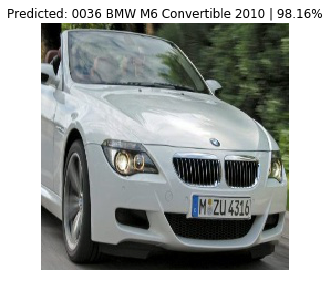

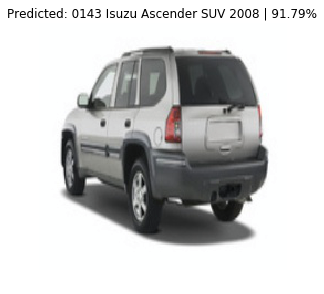

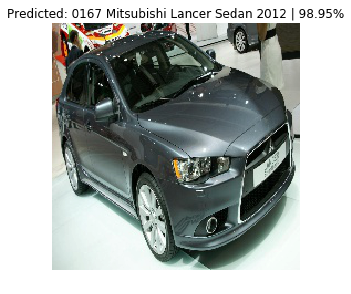

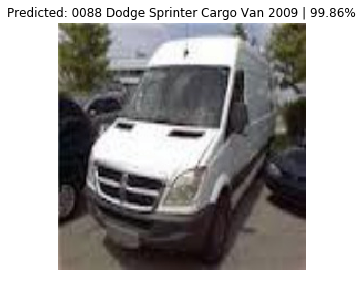

In [92]:
visualize_model(model)

plt.ioff()
plt.show()